In [1]:

import torch
from torch import nn
from torch import optim
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR

from torchsummary import summary
import imageVisualizationHelper 
from custom_resnet import ResNet
import commonHelper
import trainLoopHelper
import testLoopHelper
import datasetProvider

c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
DATA_FOLDER = "../../data"
from torch.utils.data import Dataset
image_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device = commonHelper.get_device(use_seed=True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

---->TRAINING data with transform


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


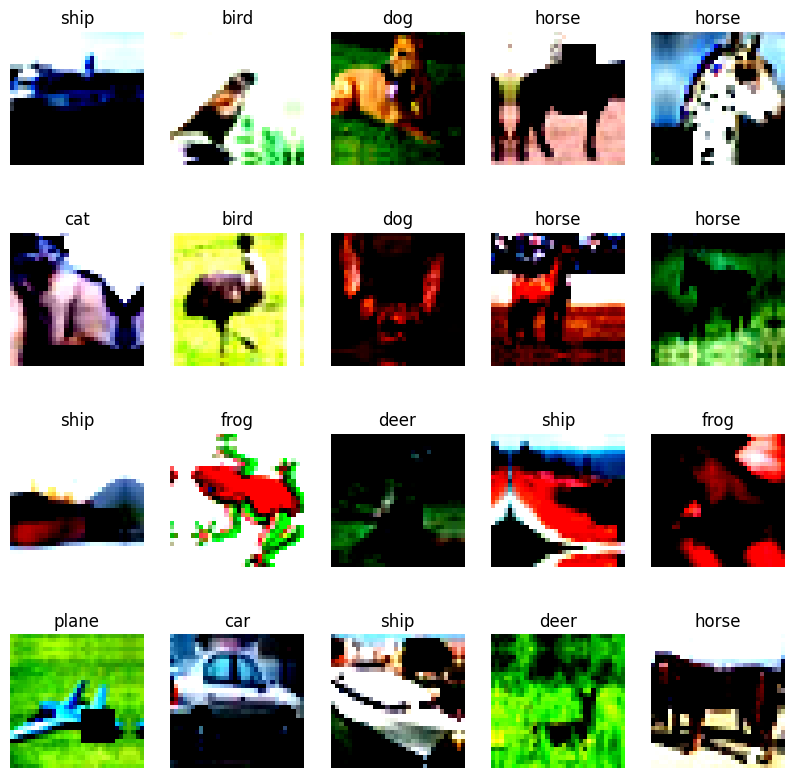

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


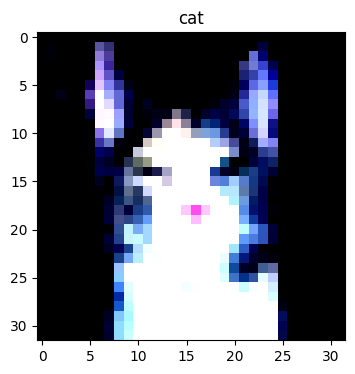

In [3]:

# Download training data from open datasets.
train_transforms_collection = []
train_transforms_collection.extend(datasetProvider.create_random_resize_crop_transformation())
train_transforms_collection.append(datasetProvider.create_flip_transformation(is_horizontal=True))
train_transforms_collection.append(datasetProvider.create_coarse_drop_out_transformation(max_height=8, max_width=8, fill_value=[0.4914, 0.4822, 0.4465]))
train_transforms_collection.extend(datasetProvider.create_basic_transforms_collection())

train_transforms = datasetProvider.compose_custom_transforms(train_transforms_collection)
test_transforms = datasetProvider.compose_custom_transforms(datasetProvider.create_basic_transforms_collection())

train_dataset, test_dataset = datasetProvider.get_CIFAR10_datasets(train_transforms_collection=train_transforms,
                                                                   test_transforms_collection=test_transforms,
                                                                    data_folder=DATA_FOLDER)

print("---->TRAINING data with transform")
imageVisualizationHelper.randomly_show_images_from_tensor_array(train_dataset, image_classes, rows=4, cols=5)


# print("---->TEST data with transform")
# imageVisualizationHelper.randomly_show_images_from_tensor_array(test_dataset, image_classes, rows=4, cols=4)

# Show single image
sample_idx = torch.randint(0, len(test_dataset), size=(1,))  
image_data, label = test_dataset[sample_idx.item()]
imageVisualizationHelper.show_image(image_data, image_classes[label])


In [4]:

BATCH_SIZE = 512
train_dataloader, test_dataloader = datasetProvider.get_dataloaders(train_dataset=train_dataset,
                                                                    test_dataset=test_dataset,
                                                                    batch_size=BATCH_SIZE)
                                                                    


Shape of test_dataloader batch_data [Batch, C, H, W]: torch.Size([512, 3, 32, 32])
Shape of test_dataloader label (label): torch.Size([512]) torch.int64
Labels for a batch of size 512 are tensor([0, 6, 8, 4, 8, 5, 1, 0, 7, 4, 3, 3, 3, 0, 4, 8, 4, 9, 9, 4, 6, 7, 7, 3,
        3, 5, 9, 4, 1, 0, 2, 8, 5, 0, 2, 5, 7, 4, 6, 6, 3, 6, 7, 8, 9, 7, 1, 2,
        4, 1, 4, 9, 6, 5, 7, 7, 8, 6, 4, 6, 3, 1, 8, 1, 9, 9, 7, 9, 7, 1, 9, 0,
        9, 9, 2, 8, 4, 5, 2, 1, 6, 7, 9, 6, 5, 4, 2, 6, 4, 2, 5, 6, 6, 0, 3, 6,
        6, 1, 9, 1, 8, 7, 4, 4, 1, 9, 1, 1, 7, 0, 3, 3, 9, 9, 6, 7, 3, 4, 3, 1,
        1, 3, 2, 9, 4, 0, 4, 8, 0, 3, 9, 6, 5, 1, 3, 0, 9, 5, 3, 9, 4, 8, 6, 8,
        0, 0, 8, 6, 4, 0, 1, 7, 3, 2, 4, 0, 7, 6, 8, 0, 9, 6, 9, 3, 1, 1, 3, 6,
        3, 2, 8, 7, 3, 5, 1, 6, 4, 5, 3, 9, 8, 1, 0, 5, 0, 8, 0, 3, 4, 1, 3, 1,
        7, 9, 8, 5, 5, 1, 1, 5, 5, 5, 1, 6, 8, 2, 9, 1, 6, 3, 4, 4, 4, 1, 2, 3,
        6, 4, 3, 2, 6, 4, 1, 5, 2, 7, 2, 4, 3, 2, 2, 2, 1, 6, 5, 2, 4, 9, 2, 1,
        0, 1

In [5]:
def get_model_instance(index=1, input_size=(3,32,32)) -> nn.Module:
    if(index <= 1 ):
        model = ResNet().to(device=device)
        summary(model=model, input_size=input_size)
        return model


model = get_model_instance(index=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 32, 32]          73,728
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
          Dropout-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]         147,456
      BatchNorm2d-14          [-1, 128,

In [6]:
def get_correct_prediction_count(predictions : torch.Tensor, valid_labels):
  # torch.argmax locates the indices of the maximum elements within a tensor.
  # It does this along a specified dimension (axis).
  return predictions.argmax(dim=1).eq(valid_labels).sum().item()

In [7]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []

train_accuracy = []
test_accuracy = []

MAX_IMAGES_FOR_DISPLAY = 20

correctly_predicted_trained_images = []
wrongly_predicted_trained_images = []

correctly_predicted_test_images = []
wrongly_predicted_test_images = []

In [8]:

def train_loop(dataloader, model, loss_fn, optimizer : optim.Optimizer):
    batch_train_accuracy, batch_train_losses, correctly_predicted_images, wrongly_predicted_images = trainLoopHelper.train_loop(dataloader, model, loss_fn, optimizer)
    train_accuracy.append(batch_train_accuracy)
    train_losses.append(batch_train_losses)

    if(len(correctly_predicted_trained_images) < MAX_IMAGES_FOR_DISPLAY):
        correctly_predicted_trained_images.extend(correctly_predicted_images)

    if(len(wrongly_predicted_trained_images) < MAX_IMAGES_FOR_DISPLAY):
        wrongly_predicted_trained_images.extend(wrongly_predicted_images)


In [9]:


def test_loop(dataloader, model, loss_fn):

        batch_test_accuracy, batch_test_losses, correctly_predicted_images, wrongly_predicted_images = testLoopHelper.test_loop(dataloader, model, loss_fn)
        test_accuracy.append(batch_test_accuracy)
        test_losses.append(batch_test_losses)

        if(len(correctly_predicted_test_images) < MAX_IMAGES_FOR_DISPLAY):
            correctly_predicted_test_images.extend(correctly_predicted_images)

        if(len(wrongly_predicted_test_images) < MAX_IMAGES_FOR_DISPLAY):
            wrongly_predicted_test_images.extend(wrongly_predicted_images)


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.45E-02


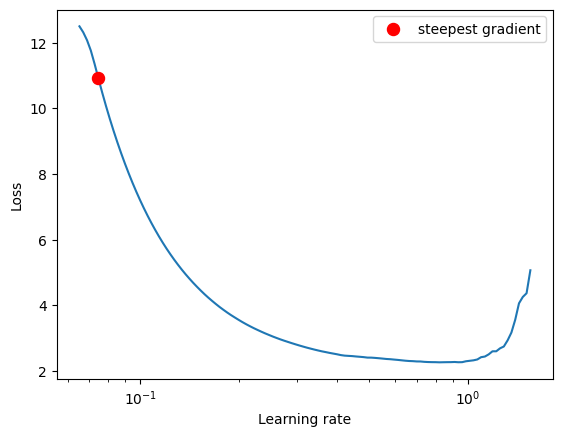

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dataloader, end_lr=10, num_iter=200, step_mode="exp")

lr_finder.plot()
lr_finder.reset()

In [11]:
# LEARNING_RATE = 0.01
EPOCHS = 24
# MOMENTUM = 0.85

correctly_predicted_trained_images = []
wrongly_predicted_trained_images = []
correctly_predicted_test_images = []
wrongly_predicted_test_images = []

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=7.45E-02,
                                                pct_start = 5/EPOCHS,
                                                div_factor=100,
                                                final_div_factor=1000,
                                                anneal_strategy = "linear",
                                                steps_per_epoch=len(train_dataloader),
                                                epochs=EPOCHS)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8, verbose=True)


for t in range(EPOCHS):
    print(f"Epoch {t+1}")
    train_loop(train_dataloader, model, criterion, optimizer)
    test_loop(test_dataloader, model, criterion)
    scheduler.step()

print("Done!")

Epoch 1


Train: Loss=2.7999 Batch_id=0 Accuracy=9.18:   0%|          | 0/98 [00:23<?, ?it/s]

Train loop parameters shapes
 Shape of data : torch.Size([512, 3, 32, 32]), label: torch.Size([512])
Shape of predicted data : torch.Size([512, 10])
labels : tensor([3, 6, 1, 3, 7, 1, 0, 2, 0, 5, 4, 4, 7, 1, 4, 0, 7, 6, 4, 1, 7, 0, 8, 2,
        9, 6, 8, 2, 0, 2, 6, 3, 7, 7, 3, 4, 0, 8, 8, 5, 1, 8, 7, 5, 9, 2, 6, 6,
        6, 1, 4, 2, 9, 6, 4, 9, 3, 4, 0, 8, 0, 5, 7, 2, 3, 8, 7, 7, 2, 7, 9, 9,
        6, 5, 5, 2, 1, 9, 8, 2, 2, 3, 8, 9, 1, 7, 9, 3, 7, 8, 3, 2, 3, 4, 9, 1,
        2, 0, 6, 1, 9, 0, 7, 6, 0, 3, 1, 9, 6, 3, 9, 2, 3, 0, 2, 6, 7, 5, 3, 1,
        3, 9, 0, 8, 2, 6, 3, 7, 6, 8, 3, 0, 5, 6, 5, 6, 2, 4, 8, 3, 9, 0, 4, 6,
        3, 8, 9, 2, 9, 4, 3, 5, 9, 2, 1, 1, 2, 8, 8, 1, 6, 0, 1, 2, 9, 4, 3, 0,
        3, 8, 6, 2, 1, 3, 3, 6, 6, 5, 1, 5, 7, 2, 9, 1, 6, 8, 7, 4, 0, 3, 1, 5,
        5, 5, 1, 9, 1, 0, 6, 7, 3, 2, 7, 5, 5, 9, 4, 5, 0, 7, 6, 4, 8, 4, 7, 4,
        1, 4, 0, 0, 2, 7, 4, 5, 6, 1, 0, 7, 3, 4, 9, 8, 4, 9, 5, 5, 1, 1, 5, 7,
        3, 9, 1, 2, 8, 8, 7, 3, 1, 1, 0, 8

Train: Loss=1.0526 Batch_id=97 Accuracy=47.62: 100%|██████████| 98/98 [00:48<00:00,  2.02it/s]


Test loop parameters shapes
 Shape of data : torch.Size([512, 3, 32, 32]), label: torch.Size([512])
Shape of predicted data : torch.Size([512, 10])
labels : tensor([7, 4, 7, 8, 6, 8, 8, 1, 6, 4, 9, 1, 7, 8, 0, 0, 2, 1, 7, 2, 9, 1, 1, 1,
        9, 9, 3, 6, 4, 9, 8, 9, 5, 1, 1, 4, 0, 3, 1, 0, 8, 0, 5, 2, 0, 9, 9, 7,
        6, 2, 2, 1, 8, 1, 8, 1, 3, 4, 9, 4, 6, 6, 1, 0, 9, 7, 4, 8, 6, 0, 7, 4,
        6, 6, 1, 5, 3, 4, 6, 5, 5, 9, 5, 4, 4, 7, 0, 0, 1, 3, 1, 0, 0, 3, 3, 8,
        7, 1, 1, 4, 9, 9, 5, 5, 8, 5, 0, 4, 6, 0, 3, 2, 8, 8, 7, 9, 7, 5, 7, 5,
        1, 0, 7, 2, 2, 7, 4, 8, 0, 7, 9, 1, 4, 8, 1, 0, 6, 8, 5, 3, 0, 4, 3, 4,
        0, 8, 0, 0, 7, 4, 6, 0, 4, 1, 3, 5, 5, 4, 8, 6, 3, 8, 6, 0, 0, 6, 5, 1,
        0, 0, 0, 4, 4, 4, 7, 7, 2, 2, 8, 1, 0, 0, 3, 6, 2, 3, 7, 7, 4, 7, 3, 8,
        5, 9, 4, 9, 2, 3, 1, 3, 1, 3, 8, 3, 7, 5, 0, 0, 4, 5, 7, 3, 4, 2, 2, 4,
        9, 5, 1, 7, 9, 6, 4, 5, 4, 1, 0, 9, 9, 5, 0, 0, 4, 2, 2, 9, 6, 4, 2, 1,
        4, 5, 6, 1, 3, 3, 1, 1, 4, 4, 6, 8,

Train: Loss=0.8215 Batch_id=97 Accuracy=65.94: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 18.5070, Accuracy: 6827/10000 (68.27%)

Epoch 3


Train: Loss=0.6734 Batch_id=97 Accuracy=73.13: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 13.1066, Accuracy: 7766/10000 (77.66%)

Epoch 4


Train: Loss=0.5296 Batch_id=97 Accuracy=77.99: 100%|██████████| 98/98 [00:48<00:00,  2.02it/s]


Test set: Average loss: 12.1023, Accuracy: 7979/10000 (79.79%)

Epoch 5


Train: Loss=0.4646 Batch_id=97 Accuracy=80.37: 100%|██████████| 98/98 [00:48<00:00,  2.00it/s]


Test set: Average loss: 10.3155, Accuracy: 8237/10000 (82.37%)

Epoch 6


Train: Loss=0.6251 Batch_id=97 Accuracy=82.83: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]


Test set: Average loss: 9.8364, Accuracy: 8311/10000 (83.11%)

Epoch 7


Train: Loss=0.5292 Batch_id=97 Accuracy=84.66: 100%|██████████| 98/98 [00:48<00:00,  2.04it/s]


Test set: Average loss: 10.8937, Accuracy: 8110/10000 (81.10%)

Epoch 8


Train: Loss=0.3842 Batch_id=97 Accuracy=85.54: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]


Test set: Average loss: 8.2649, Accuracy: 8579/10000 (85.79%)

Epoch 9


Train: Loss=0.4237 Batch_id=97 Accuracy=86.69: 100%|██████████| 98/98 [00:47<00:00,  2.04it/s]


Test set: Average loss: 9.6422, Accuracy: 8418/10000 (84.18%)

Epoch 10


Train: Loss=0.3717 Batch_id=97 Accuracy=87.79: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 9.5330, Accuracy: 8424/10000 (84.24%)

Epoch 11


Train: Loss=0.4195 Batch_id=97 Accuracy=88.08: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


Test set: Average loss: 8.8636, Accuracy: 8475/10000 (84.75%)

Epoch 12


Train: Loss=0.2945 Batch_id=97 Accuracy=88.35: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]


Test set: Average loss: 8.2629, Accuracy: 8644/10000 (86.44%)

Epoch 13


Train: Loss=0.2991 Batch_id=97 Accuracy=89.04: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]


Test set: Average loss: 9.8947, Accuracy: 8408/10000 (84.08%)

Epoch 14


Train: Loss=0.3388 Batch_id=97 Accuracy=89.25: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 8.9810, Accuracy: 8555/10000 (85.55%)

Epoch 15


Train: Loss=0.3666 Batch_id=97 Accuracy=89.28: 100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


Test set: Average loss: 8.2327, Accuracy: 8663/10000 (86.63%)

Epoch 16


Train: Loss=0.3700 Batch_id=97 Accuracy=89.36: 100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


Test set: Average loss: 8.3926, Accuracy: 8671/10000 (86.71%)

Epoch 17


Train: Loss=0.3962 Batch_id=97 Accuracy=89.94: 100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


Test set: Average loss: 8.6689, Accuracy: 8591/10000 (85.91%)

Epoch 18


Train: Loss=0.3118 Batch_id=97 Accuracy=90.23: 100%|██████████| 98/98 [00:47<00:00,  2.08it/s]


Test set: Average loss: 7.8317, Accuracy: 8690/10000 (86.90%)

Epoch 19


Train: Loss=0.2441 Batch_id=97 Accuracy=89.68: 100%|██████████| 98/98 [00:45<00:00,  2.15it/s]


Test set: Average loss: 9.4771, Accuracy: 8491/10000 (84.91%)

Epoch 20


Train: Loss=0.2703 Batch_id=97 Accuracy=89.39: 100%|██████████| 98/98 [00:44<00:00,  2.23it/s]


Test set: Average loss: 8.6437, Accuracy: 8626/10000 (86.26%)

Epoch 21


Train: Loss=0.3118 Batch_id=97 Accuracy=89.55: 100%|██████████| 98/98 [00:45<00:00,  2.17it/s]


Test set: Average loss: 10.2786, Accuracy: 8389/10000 (83.89%)

Epoch 22


Train: Loss=0.2317 Batch_id=97 Accuracy=89.74: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Test set: Average loss: 9.8685, Accuracy: 8458/10000 (84.58%)

Epoch 23


Train: Loss=0.3529 Batch_id=97 Accuracy=90.08: 100%|██████████| 98/98 [00:48<00:00,  2.00it/s]


Test set: Average loss: 8.4815, Accuracy: 8613/10000 (86.13%)

Epoch 24


Train: Loss=0.2960 Batch_id=97 Accuracy=90.62: 100%|██████████| 98/98 [00:47<00:00,  2.08it/s]


Test set: Average loss: 7.7550, Accuracy: 8730/10000 (87.30%)

Done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----****----Wrongly predicted test images: 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


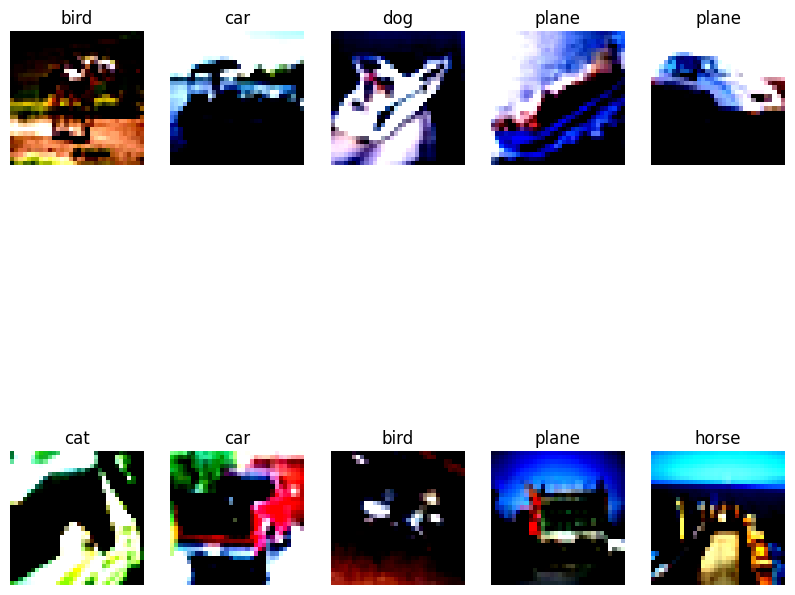

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----****----Correctly predicted test images: 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


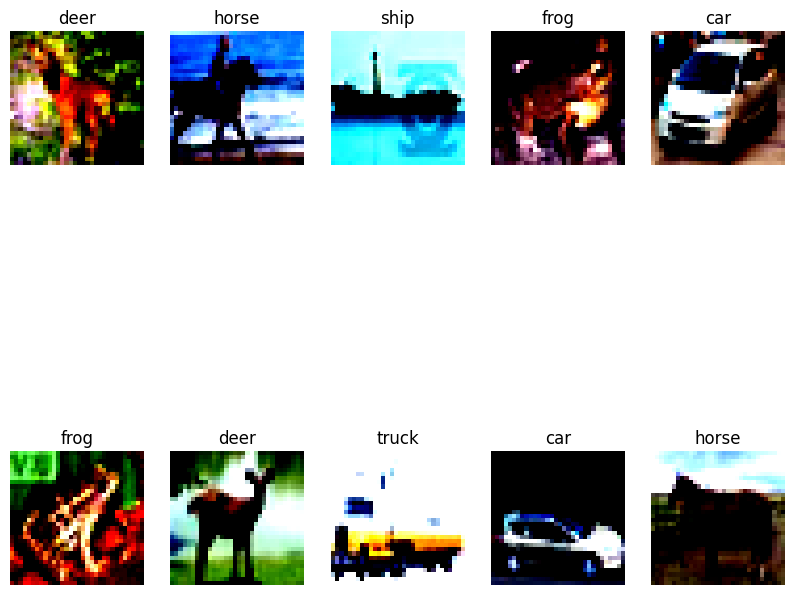

In [12]:

print(f"----****----Wrongly predicted test images: {len(wrongly_predicted_test_images)}")
imageVisualizationHelper.show_images_from_tensor_array(wrongly_predicted_test_images, image_classes, rows=2, cols=5)

print(f"----****----Correctly predicted test images: {len(correctly_predicted_test_images)}")
imageVisualizationHelper.show_images_from_tensor_array(correctly_predicted_test_images, image_classes, rows=2, cols=5)


# print(f"----****----Wrongly predicted train images: {len(wrongly_predicted_trained_images)}")
# imageVisualizationHelper.show_images_from_tensor_array(wrongly_predicted_trained_images, image_classes, rows=2, cols=5)

# print(f"----****----Correctly predicted train images: {len(correctly_predicted_trained_images)}")
# imageVisualizationHelper.show_images_from_tensor_array(correctly_predicted_trained_images, image_classes, rows=2, cols=5)
